Feature: Sensitivity Mapping
============================

Bayesian model comparison allows us to take a dataset, fit it with multiple models and use the Bayesian evidence to
quantify which model objectively gives the best-fit following the principles of Occam's Razor.

However, a complex model may not be favoured by model comparison not because it is the 'wrong' model, but simply
because the dataset being fitted is not of a sufficient quality for the more complex model to be favoured. Sensitivity
mapping allows us to address what quality of data would be needed for the more complex model to be favoured or
alternatively for what sets of model parameter values it would be favoured for data of a given quality.

In order to do this, sensitivity mapping involves us writing a function that uses the model(s) to simulate a dataset.
We then use this function to simulate many datasets, for many different models, and fit each dataset using the same
model-fitting procedure we used to perform Bayesian model comparison. This allows us to infer how much of a Bayesian
evidence increase we should expect for datasets of varying quality and / or models with different parameters.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autofit as af
import model as m
import analysis as a

import matplotlib.pyplot as plt
import numpy as np
from os import path

/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace`


__Data__

First, lets load data of a 1D Gaussian, by loading it from a .json file in the directory 
`autofit_workspace/dataset/gaussian_x1_with_feature`.

This 1D data includes a small feature to the right of the central `Gaussian`. This feature is a second `Gaussian` 
centred on pixel 70. 

In [2]:
dataset_path = path.join("dataset", "example_1d", "gaussian_x1_with_feature")
data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))
noise_map = af.util.numpy_array_from_json(
    file_path=path.join(dataset_path, "noise_map.json")
)

Now lets plot the data, including its error bars. 

The feature on pixel 70 is clearly visible.

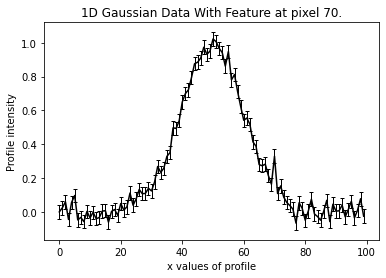

In [3]:
xvalues = range(data.shape[0])

plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.title("1D Gaussian Data With Feature at pixel 70.")
plt.xlabel("x values of profile")
plt.ylabel("Profile intensity")
plt.show()
plt.close()

__Analysis__

Our Analysis class is described in `analysis.py` and is the same used in the `overview/complex` example. 

It fits the data as the sum of the two `Gaussian`'s in the model.

In [4]:
analysis = a.Analysis(data=data, noise_map=noise_map)

__Model Comparison__

Before performing sensitivity mapping, we will quickly perform Bayesian model comparison on this data to get a sense 
for whether the `Gaussian` feature is detectable and how much the Bayesian evidence increases when it is included in
the model.

We therefore fit the data using two models, one where the model is a single `Gaussian` and one where it is 
two `Gaussians`. 

To avoid slow model-fitting and more clearly prounce the results of model comparison, we restrict the centre of 
the`gaussian_feature` to its true centre of 70 and sigma value of 0.5.

In [5]:
model = af.CollectionPriorModel(gaussian_main=m.Gaussian)

dynesty = af.DynestyStatic(
    path_prefix=path.join("features", "sensitivity_mapping", "single_gaussian"),
    n_live_points=100,
    iterations_per_update=500,
)

result_single = dynesty.fit(model=model, analysis=analysis)

model = af.CollectionPriorModel(gaussian_main=m.Gaussian, gaussian_feature=m.Gaussian)
model.gaussian_feature.centre = 70.0
model.gaussian_feature.sigma = 0.5

dynesty = af.DynestyStatic(
    path_prefix=path.join("features", "sensitivity_mapping", "two_gaussians"),
    n_live_points=100,
    iterations_per_update=500,
)

result_multiple = dynesty.fit(model=model, analysis=analysis)

INFO:root: already completed, skipping non-linear search.
INFO:root: already completed, skipping non-linear search.


We can now print the `log_evidence` of each fit and confirm the model with two `Gaussians` was preferred to the model
with just one `Gaussian`.

In [6]:
print(result_single.samples.log_evidence)
print(result_multiple.samples.log_evidence)

-72.53551750257468
-65.67553233696172


__Sensitivity Mapping__

The model comparison above shows that in this dataset, the `Gaussian` feature was detectable and that it increased the 
Bayesian evidence by ~25. Furthermore, the intensity of this `Gaussian` was ~0.3. 

A lower value of intensity makes the `Gaussian` fainter and harder to detect. We will demonstrate sensitivity mapping 
by answering the following question, at what value of intensity does the `Gaussian` feature become undetectable and
not provide us with a noticeable increase in Bayesian evidence?

To begin, we define the `base_model` that we use to perform sensitivity mapping. This model is used to simulate every 
dataset. It is also fitted to every simulated dataset without the extra model component below, to give us the Bayesian
evidence of the every simpler model to compare to the more complex model. 

The `base_model` corresponds to the `gaussian_main` above.

In [7]:
base_model = af.CollectionPriorModel(gaussian_main=m.Gaussian)

We now define the `perturbation_model`, which is the model component whose parameters we iterate over to perform 
sensitivity mapping. Many instances of the `perturbation_model` are created and used to simulate the many datasets 
that we fit. However, it is only included in half of the model-fits corresponding to the more complex models whose
Bayesian evidence we compare to the simpler model-fits consisting of just the `base_model`.

The `perturbation_model` is therefore another `Gaussian` but now corresponds to the `gaussian_feature` above.

By fitting both of these models to every simulated dataset, we will therefore infer the Bayesian evidence of every
model to every dataset. Sensitivity mapping therefore maps out for what values of `intensity` in the `gaussian_feature`
 does the more complex model-fit provide higher values of Bayesian evidence than the simpler model-fit.

In [8]:
perturbation_model = af.PriorModel(m.Gaussian)

Sensitivity mapping is typically performed over a large range of parameters. However, to make this demonstration quick
and clear we are going to fix the `centre` and `sigma` values to the true values of the `gaussian_feature`. We will 
also iterate over just two `intensity` values corresponding to 0.01 and 100.0, which will clearly exhaggerate the
sensitivity between the models at these two values.

In [9]:
perturbation_model.centre = 70.0
perturbation_model.sigma = 0.5
perturbation_model.intensity = af.UniformPrior(lower_limit=0.01, upper_limit=100.0)

We are performing sensitivity mapping to determine how bright the `gaussian_feature` needs to be in order to be 
detectable. However, every simulated dataset must include the `main_gaussian`, as its presence in the data will effect
the detectability of the `gaussian_feature`.

We can pass the `main_gaussian` into the sensitivity mapping as the `base_instance`, meaning that it will be used 
in the simulation of every dataset. For this example we use the inferred `main_gaussian` from one of the model-fits
performed above.

In [10]:
base_instance = result_single.instance

We are about to write a `simulate_function` that simulates examples of 1D `Gaussian` datasets that are fitted to
perform sensitivity mapping.

To pass each simulated data through **PyAutoFit**'s sensitivity mapping tools, the function must return a single 
Python object. We therefore define a `Dataset` class that combines the `data` and `noise_map` that are to be 
output by this `simulate_function`.

In [11]:


class Dataset:
    def __init__(self, data, noise_map):

        self.data = data
        self.noise_map = noise_map


We now write the `simulate_function`, which takes the `instance` of our model (defined above) and uses it to 
simulate a dataset which is subsequently fitted.

Note that when this dataset is simulated, the quantity `instance.perturbation` is used in the `simulate_function`.
This is an instance of the `gaussian_feature`, and it is different every time the `simulate_function` is called. 

In this example, this `instance.perturbation` corresponds to two different `gaussian_feature` with values of
`intensity` of 0.01 and 100.0, such that our simulated datasets correspond to a very faint and very bright gaussian 
features .

In [12]:


def simulate_function(instance):

    """
    Specify the number of pixels used to create the xvalues on which the 1D line of the profile is generated using and
    thus defining the number of data-points in our data.
    """
    pixels = 100
    xvalues = np.arange(pixels)

    """
    Evaluate the `Gaussian` and Exponential model instances at every xvalues to create their model profile and sum
    them together to create the overall model profile.
    
    This print statement will show that, when you run `Sensitivity` below the values of the perturbation use fixed 
    values of `centre=70` and `sigma=0.5`, whereas the intensity varies over the `step_size` based on its prior.
    """

    print(instance.perturbation.centre)
    print(instance.perturbation.intensity)
    print(instance.perturbation.sigma)

    model_line = instance.gaussian_main.profile_from_xvalues(
        xvalues=xvalues
    ) + instance.perturbation.profile_from_xvalues(xvalues=xvalues)

    """Determine the noise (at a specified signal to noise level) in every pixel of our model profile."""
    signal_to_noise_ratio = 25.0
    noise = np.random.normal(0.0, 1.0 / signal_to_noise_ratio, pixels)

    """
    Add this noise to the model line to create the line data that is fitted, using the signal-to-noise ratio to compute
    noise-map of our data which is required when evaluating the chi-squared value of the likelihood.
    """
    data = model_line + noise
    noise_map = (1.0 / signal_to_noise_ratio) * np.ones(pixels)

    return Dataset(data=data, noise_map=noise_map)


Each model-fit performed by sensitivity mapping creates a new instance of an `Analysis` class, which contains the
data simulated by the `simulate_function` for that model.

This requires us to write a wrapper around the `Analysis` class that we used to fit the model above, so that is uses
the `Dataset` object above.

In [13]:


class Analysis(a.Analysis):
    def __init__(self, dataset):

        super().__init__(data=dataset.data, noise_map=dataset.noise_map)


We next specify the search used to perform each model fit by the sensitivity mapper.

In [14]:
search = af.DynestyStatic(
    path_prefix=path.join("features", "sensitivity_mapping", "sensitivity_map"),
    n_live_points=100,
    iterations_per_update=500,
)

We can now combine all of the objects created above and perform sensitivity mapping. The inputs to the `Sensitivity`
object below are:

- base_instance: This is an instance of the model used to simulate every dataset that is fitted. In this example it 
contains an instance of the `gaussian_main` model component.

- base_model: This is the simpler model that is fitted to every simulated dataset, which in this example is composed of 
a single `Gaussian` called the `gaussian_main`.

- perturbation_model: This is the extra model component that alongside the `base_model` is fitted to every simulated 
dataset, which in this example  is composed of two `Gaussians` called the `gaussian_main` and `gaussian_feature`.

- simulate_function: This is the function that uses the `instance` and many instances of the `pertubation_model` to
simulate many datasets that are fitted with the `base_model` and `base_model` + `perturbation_model`.

- analysis_class: The wrapper `Analysis` class defined above that passes each simulated dataset to the `Analysis` class
that fits the data.

- step_size: The size of steps over which the parameters in the `perturbation_model` are iterated. In this example, 
intensity has a `LogUniformPrior` with lower limit 1e-4 and upper limit 1e2, therefore the `step_size` of 0.5 will
simulate and fit just 2 datasets where the intensity is 1e-4 and 1e2.

- number_of_cores: The number of cores over which the sensitivity mapping is performed, enabling parallel processing.

In [15]:
from autofit.non_linear.grid import sensitivity as s

sensitivity = s.Sensitivity(
    search=search,
    base_instance=base_instance,
    base_model=base_model,
    perturbation_model=perturbation_model,
    simulate_function=simulate_function,
    analysis_class=Analysis,
    step_size=0.5,
    number_of_cores=2,
)

sensitivity_result = sensitivity.run()

INFO:root:created process 0


70.0
25.0075
0.5
70.0
75.0025
0.5


INFO:root:starting process 0
INFO:root:dynesty_static[nlive_100__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/intensity_25.0075 already completed, skipping non-linear search.
INFO:root:dynesty_static[nlive_100__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/intensity_25.0075 already completed, skipping non-linear search.
INFO:root:dynesty_static[nlive_100__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/intensity_75.0025 already completed, skipping non-linear search.
INFO:root:dynesty_static[nlive_100__bound_multi_vol_dec_0.5_vol_check_2.0__enlarge_1.0__sample_auto]/intensity_75.0025 already completed, skipping non-linear search.


You should now look at the results of the sensitivity mapping in the folder `output/features/sensitivity_mapping`. 

You will note the following 4 model-fits have been performed:

 - The `base_model` is fitted to a simulated dataset where the `base_instance` and 
 a `perturbation` with intensity is 0.01 are used.

 - The `base_model` + `pertubation_model`  is fitted to a simulated dataset where the `base_instance` and 
 a `perturbation` with intensity is 0.01 are used.

 - The `base_model` is fitted to a simulated dataset where the `base_instance` and 
 a `perturbation` with intensity is 100.0 are used.

 - The `base_model` + `pertubation_model`  is fitted to a simulated dataset where the `base_instance` and 
 a `perturbation` with intensity is 100.0 are used.

The fit produced a `sensitivity_result`. 

We are still developing the `SensitivityResult` class to provide a data structure that better streamlines the analysis
of results. If you intend to use sensitivity mapping, the best way to interpret the resutls is currently via
**PyAutoFit**'s database and `Aggregator` tools. 

In [16]:
print(sensitivity_result.results[0].result.samples.log_evidence)
print(sensitivity_result.results[1].result.samples.log_evidence)

-5709.190432202557
-5666.740253681781


Finish.